# Project Guidance

https://ds.codeup.com/nlp/project/

## Acquisition + Preparation

For this project, you will have to build a dataset yourself. Decide on a list of GitHub repositories to scrape, and use the provided script to acquire the README data for each repository. The repositories you use are up to you, but you should include at least 100 repositories in your data set.
As an example of which repositories to use, here is a link to GitHub's trending repositories, the most forked repositories, and the most starred repositories.

https://github.com/trending

https://github.com/search?o=desc&q=stars:%3E1&s=forks&type=Repositories

https://github.com/search?q=stars%3A%3E0&s=stars&type=Repositories

The list of repositories could be generated programatically using web scraping techniques.
Make sure to document where your data comes from. All of the pages linked above change over time, so it would be wise to say something like: "Our data comes from the top 100 trending repositories on GitHub as of $DATE".

## Exploration

Explore and visualize the natural language data that you have acquired. Here are some ideas for exploration:

- What are the most common words in READMEs?

- Does the length of the README vary by programming language?

- Do different programming languages use a different number of unique words?

- Are there any words that uniquely identify a programming language?

## Modeling

- Transform your documents into a form that can be used in a machine learning model. You should use the programming language of the repository as the label to predict.

- Try fitting several different models and using several different representations of the text (e.g. a simple bag of words, then also the TF-IDF values for each).

- Build a function that will take in the text of a README file and try to predict the programming language.

- If you have many different unique values in your target variable, consider narrowing down this list. For example, use the top 3 languages and then label everything else as "Other" so that you have fewer unique values to predict.

# **Github Programming Language Predictor**
##### **using Natural Language Processing**
<p align ="right">Zacharia Schmitz <br>
October 2023

---


### Rate Limits & Ethics:

Scraping

[**From GitHub Acceptable Use Policies**](https://docs.github.com/en/github/site-policy/github-acceptable-use-policies)

>"Short version: We host a wide variety of collaborative projects from all over the world, and that collaboration only works when our users are able   >to work together in good faith. While using the Service, you must comply with our Acceptable Use Policies, which include some restrictions on content >and conduct on GitHub related to user safety, intellectual property, privacy, authenticity, and other limitations. In short, be excellent to each
>other.


### Tools Utilized: 

XXXXXXXXXXXX

<div style="background-color: #; padding: 0px; ">

## <font size='10'><i>**Plan**</i></font> <font size='5'><i>→ Acquire → Prepare → Explore → Model → Deliver</i></font>

---

We'll pull 20 README pages from each language and analyze each one individually.

1. Decide Languages
2. Acquire Repos
3. Data Cleaning
4. Text Preprocessing
5. Feature Extraction
6. Model Training

<div style="background-color: #; padding: 0px; ">

## <font size='5'><i>Plan → </i></font> <font size='10'><i>**Acquire**</i></font> <font size='5'><i> → Prepare → Explore → Model → Deliver</i></font>

---

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import pickle
import wrangle as w
import re
import string
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')

### Which Languages:

First we wanted to decide on the top languages we're interested in. 

We ended up going with: Python, C#, C++, JavaScript, PHP, Swift, Java, Go, R, and Ruby

### Scrape the URLs of Trending Repositories on GitHub for each coding language, and limited to English:

For each language, visit the URL https://github.com/trending/ + **`{language}`** + ?since=daily&spoken_language_code=en.

Extract the URLs of the top trending repositories. This required parsing the HTML with BeautifulSoup, and finding the repo. 

### Scrape README files from each Repository URL:

Once we had the repo name, we then pulled the README from https://github.com" + **`{repo}`** + "/blob/master/README.md

If the README was not posted on master and returned error code 404, we then skipped to the next repo, but didn't increment our counter (all languages had 20).

### Extract the content of the README file:

Once extracted, we stored the extracted README content for each language in a CSV file with language, repo, and the context of the README.

### Run this to Check GitHub Rate Limits Before Pulling

In [2]:
# Check current rate limit with GitHub (does not count towards limit)

response = requests.get('https://api.github.com/rate_limit')
response.json()

{'resources': {'core': {'limit': 60,
   'remaining': 60,
   'reset': 1697582984,
   'used': 0,
   'resource': 'core'},
  'graphql': {'limit': 0,
   'remaining': 0,
   'reset': 1697584628,
   'used': 0,
   'resource': 'graphql'},
  'integration_manifest': {'limit': 5000,
   'remaining': 5000,
   'reset': 1697584628,
   'used': 0,
   'resource': 'integration_manifest'},
  'search': {'limit': 10,
   'remaining': 10,
   'reset': 1697581088,
   'used': 0,
   'resource': 'search'}},
 'rate': {'limit': 60,
  'remaining': 60,
  'reset': 1697582984,
  'used': 0,
  'resource': 'core'}}

### Gather Repos

In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

base_url = "https://github.com/search?q=stars%3A%3E0+language%3A{language}&type=repositories&l={language}&p={page}"

def fetch_github_data(url):
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    elif response.status_code == 429:
        print(f"Status code: {response.status_code} - Rate limit exceeded. Ending script.")
        sys.exit()
    else:
        print(f"Status code: {response.status_code} - Failed to fetch data from {url}.")
        return None

def extract_repo_links(data, processed_repos):
    repo_links = []
    for result in data["payload"]["results"]:
        owner_login = result["repo"]["repository"]["owner_login"]
        repo_name = result["repo"]["repository"]["name"]
        repo_url = f"/{owner_login}/{repo_name}"
        if repo_url not in processed_repos:
            repo_links.append(repo_url)
            processed_repos.add(repo_url)
    return repo_links

def get_readme_content(repo):
    readme_url = "https://github.com" + repo + "/blob/master/README.md"
    response = requests.get(readme_url)
    soup = BeautifulSoup(response.content, 'html.parser')
    readme_content = soup.select_one('article')
    return readme_content.get_text() if readme_content else None

def fetch_readmes(languages=["python"], num_repos=5, start_page=1, sleep_time=1, verbose=True):
    all_readmes = []
    processed_repos = set()
    
    for language in languages:
        print(f"Processing {language} repositories...")
        page = start_page
        total_processed = 0
        
        while total_processed < num_repos:
            url = base_url.format(language=language, page=page)
            data = fetch_github_data(url)
            if not data:
                print(f"Failed to fetch data for {language} on page {page}.")
                break

            repo_links = extract_repo_links(data, processed_repos)
            for repo in repo_links:
                if total_processed >= num_repos:
                    break
                readme_content = get_readme_content(repo)
                if readme_content:
                    all_readmes.append((language, repo, readme_content))
                    total_processed += 1
                    if verbose:
                        print(f"Fetched README {total_processed} of {num_repos} for {language}.")
                time.sleep(sleep_time)  # Add a delay between requests
            page += 1
        
        if num_repos > 10 and page <= num_repos // 10:
            if verbose:
                print(f"Fetching additional pages for {language}...")
            for i in range(page, num_repos // 10 + 1):
                url = BASE_URL.format(language=language, page=i)
                data = fetch_github_data(url)
                if not data:
                    print(f"Failed to fetch data for {language} on page {i}.")
                    break

                repo_links = extract_repo_links(data, processed_repos)
                for repo in repo_links:
                    if total_processed >= num_repos:
                        break
                    readme_content = get_readme_content(repo)
                    if readme_content:
                        all_readmes.append((language, repo, readme_content))
                        total_processed += 1
                        if verbose:
                            print(f"Fetched README {total_processed} of {num_repos} for {language}.")
                    time.sleep(sleep_time)  # Add a delay between requests

            print(f"Finished processing {language} repositories. Fetched a total of {total_processed} READMEs.")
    
    df = pd.DataFrame(all_readmes, columns=["language", "repo", "readme"])
    print(f"Total README Count: {len(df)}")
    return df

- With 1 second sleeps, we got 429'd (too many requests at 42 fetches)

- We'll have to either chunk it into less pages, or increase sleeps

- Took 10:11 with 5 second sleeps.

- With 2 second sleeps, it took 5:30 and we did not get rate limited.

- Trying to run all 800 at once, we kept failing for different reasons, so we broke it up, and cached as we went.

```python
base_url = "https://github.com/search?q=stars%3A%3E0+language%3A{language}&type=repositories&l={language}&p={page}"
```

```python
# Scrape Javascript
javascript = fetch_readmes(languages=['javascript'], num_repos=100, verbose=True, sleep_time=5)
javascript.to_csv('support_files/javascript_readmes.csv')
```

```python
# Scrape Python
python = fetch_readmes(languages=['python'], num_repos=100, verbose=True, sleep_time=2)
python.to_csv('support_files/python_readmes.csv')
```

```python
# Scrape Java
java = fetch_readmes(languages=['java'], num_repos=100, verbose=True, sleep_time=2)
java.to_csv('support_files/java_readmes.csv')

```python
# Scrape HTML
html = fetch_readmes(languages=['html'], num_repos=100, verbose=True)
html.to_csv('support_files/html_readmes.csv')
```

```python
# Scrape C++
cplus = fetch_readmes(languages=['c++'], num_repos=100, verbose=True)
cplus.to_csv('support_files/cplus_readmes.csv')
```

```python
# Scrape Ruby
ruby = fetch_readmes(languages=['ruby'], num_repos=100, verbose=True)
ruby.to_csv('support_files/ruby_readmes.csv')
```

```python
# Scrape Go
go = fetch_readmes(languages=['go'], num_repos=100, verbose=True)
go.to_csv('support_files/go_readmes.csv')
```

```python
# Scrape TypeScript
typescript = fetch_readmes(languages=['typescript'], num_repos=100, verbose=True)
typescript.to_csv('support_files/typescript_readmes.csv')
```

```python
# Combine them all
df = pd.concat([javascript, python, java, html, cplus, ruby, go, typescript])
```

```python
# Cache the CSV for future usage
df.to_csv('support_files/read_mes_17oct.csv', index=False)
```

**<u>ALL REPOS PULLED OCTOBER 17th FROM 12:00 to 15:39 (CST)**

<div style="background-color: #; padding: 0px; ">

## <font size='5'><i>Plan → Acquire → </i></font> <font size='10'><i>**Prepare**</i></font> <font size='5'><i> → Explore → Model → Deliver</i></font>

--- 

1. Data Cleaning: 
2. Text Preprocessing:

`language`: The target variable indicating the programming language of the repository.
    
- 10 different programming languages (C++, C#, Go, Java, Javascript, PHP, Python, R, Ruby, Swift)

`repo`: The repository's path/name.

- 20 unique repositories for each of the languages above

`readme`: The content of the repository's README.

### Data Cleaning: 

Remove any unnecessary characters, white spaces, URLs, etc., from the readme column.

### Text Preprocessing: 

Tokenize the text, convert to lowercase, remove stop words, and possibly perform stemming or lemmatization.

Tokenize the text into individual words.

In [4]:
# read in all_readmes.csv
df = pd.read_csv('support_files/read_mes_17oct.csv')

In [146]:
# Helper function to tokenize the text and remove stopwords
def preprocess_text(text):
    # Remove all newline characters
    text = re.sub(r'\n', ' ', text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Replace hyphens with spaces
    text = re.sub(r'-', ' ', text)
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # Convert to lowercase
    text = text.lower()
    # Remove extra white spaces
    text = ' '.join(text.split())
    
    # Load the list of stopwords
    stop_words = set(stopwords.words('english'))
    
    # Add use to the stop_words list
    stop_words.update(['use', 'using', 'used'])
    
    # Add code
    stop_words.update(['code', 'codes'])

    # Tokenize the text and remove stopwords
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [6]:
# Apply the preprocessing function to the 'cleaned_readme' column
df['preprocessed_readme'] = df['readme'].apply(preprocess_text)

In [7]:
# In exploration, we found some dataframes only had <10 words. We'll limit to dataframes with over 50 words for decent prediction.
df = df[df['preprocessed_readme'].str.split().str.len() > 50]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 711 entries, 0 to 799
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   language             711 non-null    object
 1   repo                 711 non-null    object
 2   readme               711 non-null    object
 3   preprocessed_readme  711 non-null    object
dtypes: object(4)
memory usage: 27.8+ KB


In [9]:
# Show one of each language from the df
df.groupby('language').first()

,repo,readme,preprocessed_readme
language,,,
c++,/netdata/netdata,"\n\n \n\n\n \n\n\nMonitor your servers, cont...",monitor servers containers applicationsin high...
go,/golang/go,The Go Programming Language\nGo is an open sou...,go programming language go open source program...
html,/krescruz/angular-materialize,angular-materialize\nangular-materialize in ac...,angular materialize angular materialize action...
java,/Snailclimb/JavaGuide,👏 重大更新！！！重磅！\n\nJavaGuide 在线阅读版（新版，推荐👍）：https:...,👏 重大更新！！！重磅！ javaguide 在线阅读版（新版，推荐👍）： javaguid...
javascript,/atom/atom,Atom\n\n\nAtom and all repositories under Atom...,atom atom repositories atom archived december ...
python,/ytdl-org/youtube-dl,\nyoutube-dl - download videos from youtube.co...,youtube dl download videos youtubecom video pl...
ruby,/activeadmin/activeadmin,Active Admin\nActive Admin is a Ruby on Rails ...,active admin active admin ruby rails framework...
typescript,/HaikuTeam/core,Animator Core\n\nAnimator Core is the runtime ...,animator core animator core runtime rendering ...


In [94]:
# Check for NA in df
df.isna().sum()

language               0
repo                   0
readme                 0
preprocessed_readme    0
readme_length          0
unique_word_count      0
dtype: int64

<div style="background-color: #; padding: 0px; ">

## <font size='5'><i>Plan → Acquire → Prepare → </i></font> <font size='10'><i>**Explore**</i></font> <font size='5'><i>→ Model → Deliver</i></font>
---

1. Most Common Words in READMEs

2. README Length by Programming Language

3. Number of Unique Words by Programming Language

4. Words Uniquely Identifying a Programming Language

5. Further Exploration

### Most Common Words in READMEs

We'll determine the most frequently occurring words across all READMEs.

In [11]:
from collections import Counter

# Tokenize the preprocessed READMEs and count the occurrences of each word
word_counts = {}
for language in df['language'].unique():
    language_readmes = df[df['language'] == language]['preprocessed_readme']
    language_word_counts = Counter(" ".join(language_readmes).split())
    word_counts[language] = language_word_counts

# Get the 5 most common words for each language
common_words = {}
for language, counts in word_counts.items():
    common_words[language] = counts.most_common(5)

# Convert the results to a DataFrame for better visualization
common_words_df = pd.DataFrame(columns=['Language', 'Word', 'Count'])
for language, words in common_words.items():
    for i, (word, count) in enumerate(words):
        common_words_df = pd.concat([common_words_df, pd.DataFrame({'Language': language, 'Word': word, 'Count': count}, index=[0])])

common_words_df

,Language,Word,Count
0,javascript,new,267
0,javascript,function,238
0,javascript,api,223
0,javascript,data,209
0,javascript,index,208
0,python,video,394
0,python,default,307
0,python,python,301
0,python,file,298
0,python,download,260


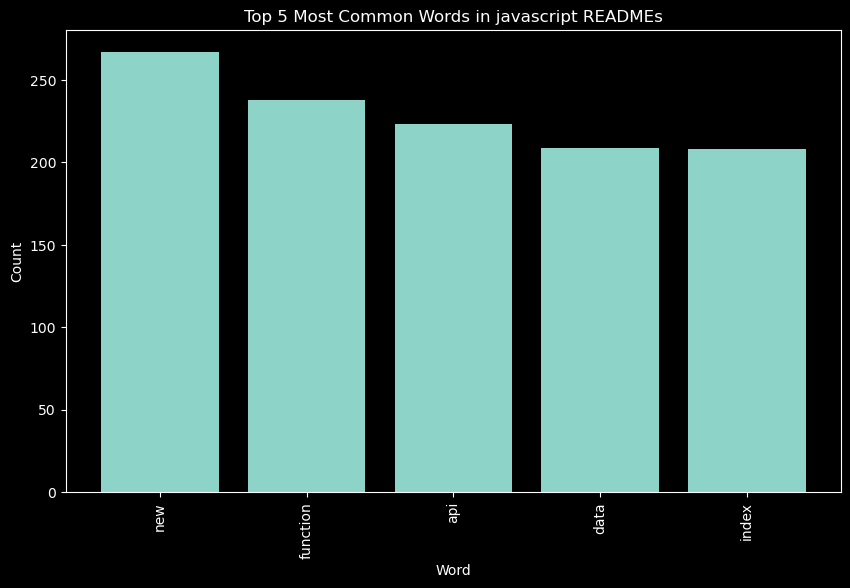

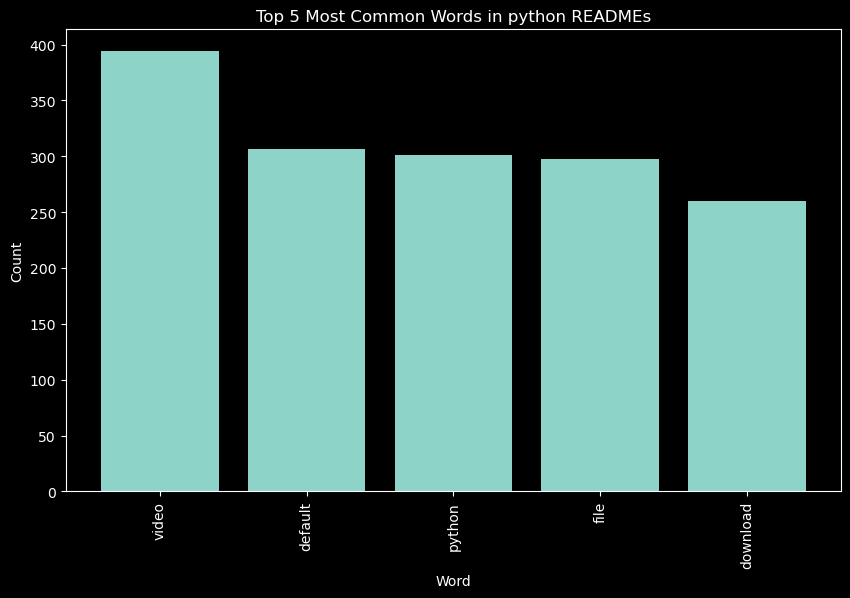

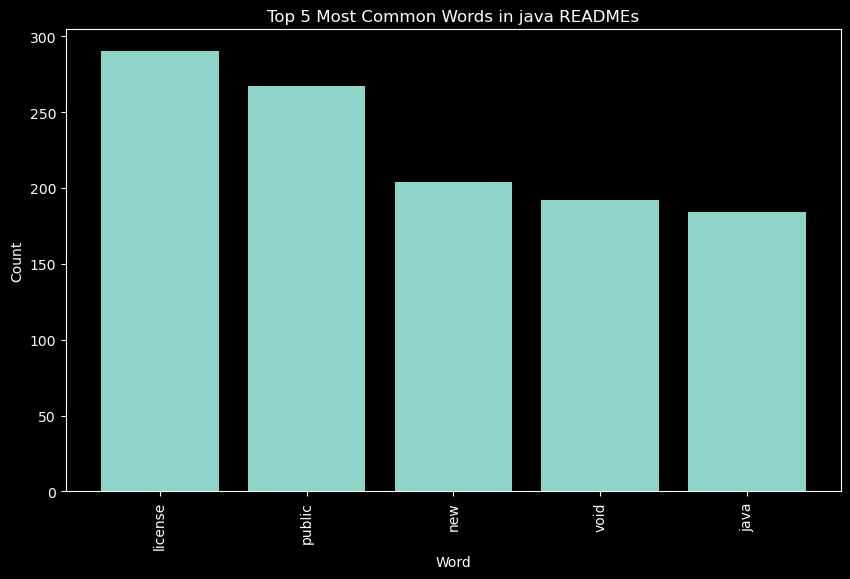

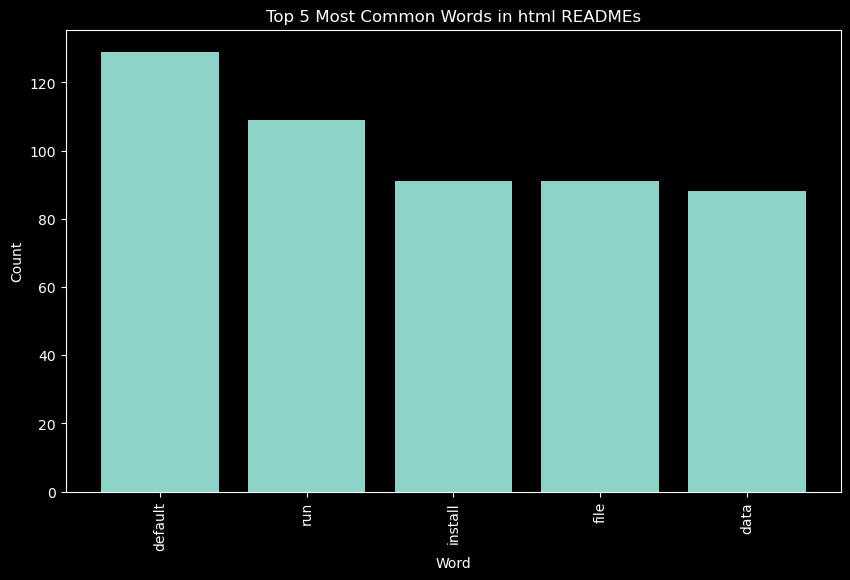

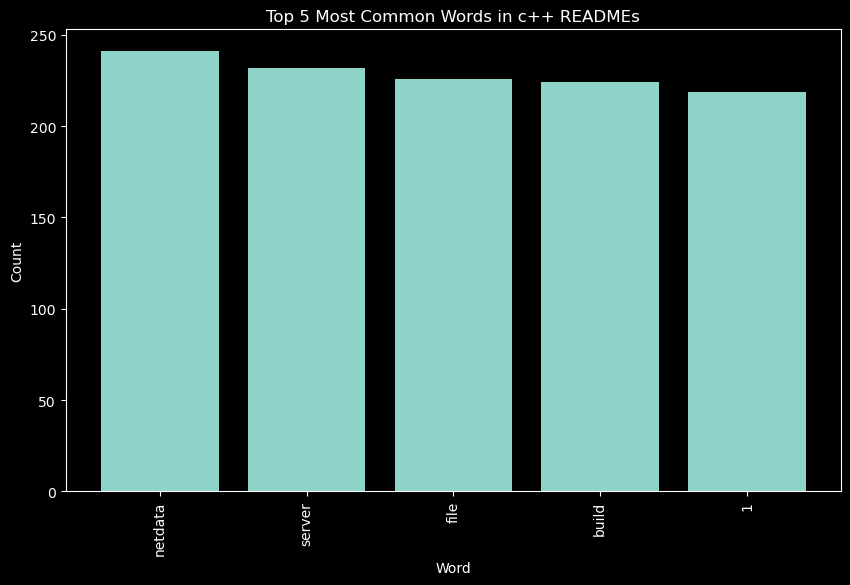

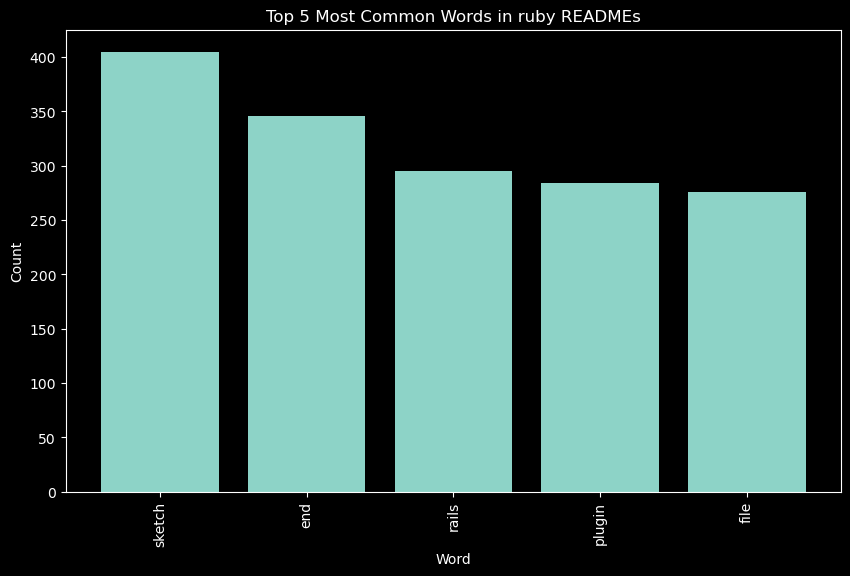

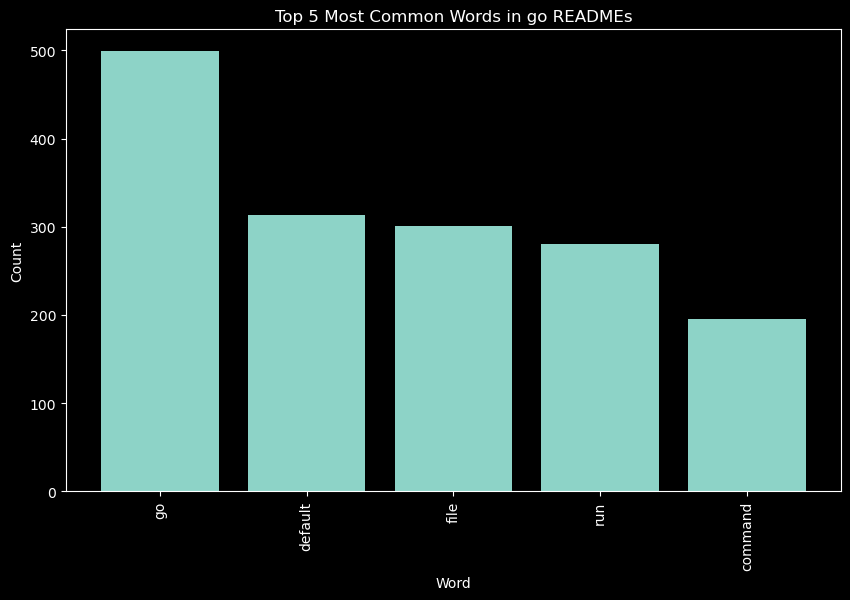

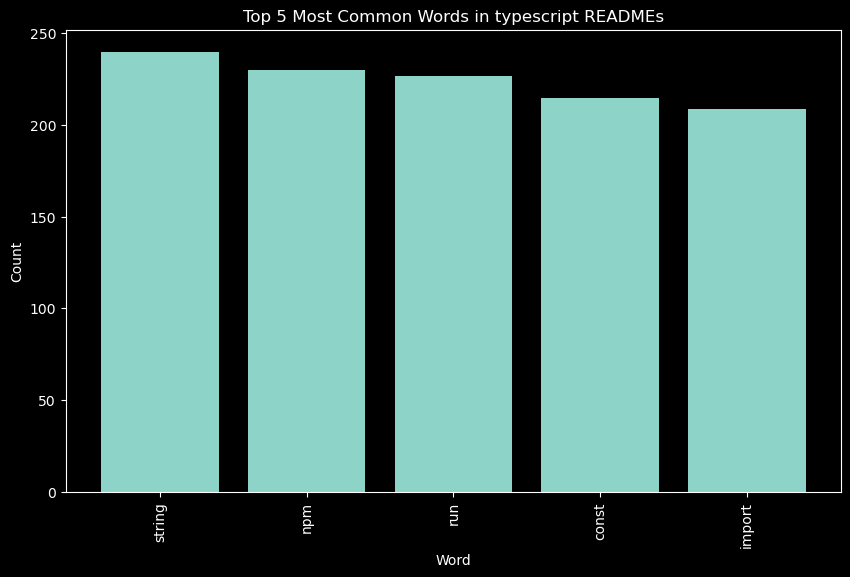

In [12]:
import matplotlib.pyplot as plt

# Create a separate plot for each language
for language in common_words.keys():
    # Get the top 20 most common words for the language
    words, counts = zip(*common_words[language])
    words = list(words)
    counts = list(counts)
    
    # Create a bar chart of the top 20 most common words for the language
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts)
    plt.title(f"Top 5 Most Common Words in {language} READMEs")
    plt.xlabel("Word")
    plt.ylabel("Count")
    plt.xticks(rotation=90)
    plt.show()

### README Length by Programming Language

We'll visualize the distribution of README lengths for each programming language to determine if there's a noticeable difference.

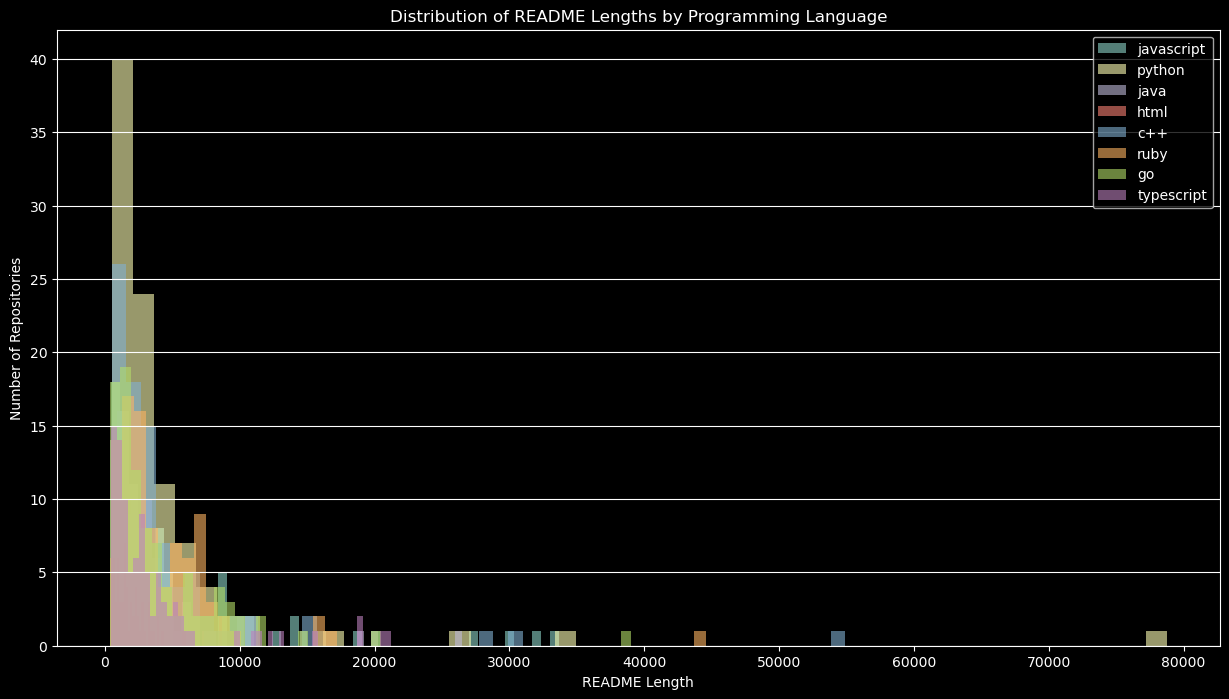

In [13]:
from matplotlib import pyplot as plt


# Calculate the length of each README
df['readme_length'] = df['preprocessed_readme'].apply(len)

# Plot the distribution of README lengths by programming language
plt.figure(figsize=(15, 8))
for lang in df['language'].unique():
    subset = df[df['language'] == lang]
    plt.hist(subset['readme_length'], bins=50, alpha=0.6, label=lang)

plt.title('Distribution of README Lengths by Programming Language')
plt.xlabel('README Length')
plt.ylabel('Number of Repositories')
plt.legend()
plt.grid(axis='y')
plt.show()

In [14]:
# Calculate the max, min, and mean README lengths by programming language
repos_summary = df.groupby('language')['readme_length'].agg(['max', 'min', 'mean'])

# Print the summary table
print(repos_summary)

              max  min         mean
language                           
c++         54915  496  4661.183908
go          39041  360  4172.440860
html         8656  378  2093.867647
java        26500  386  3359.978261
javascript  33686  414  5037.870968
python      78747  518  4636.191489
ruby        44548  407  4488.703297
typescript  21200  441  3705.946237


Most READMEs, irrespective of the programming language, tend to be similar.

Some languages, such as Java, JavaScript, and Python, have READMEs that span a wider range of lengths, from very short to very long.

Some languages, like C++, have a more concentrated distribution of README lengths, mostly towards the shorter side.

### Number of Unique Words by Programming Language

We'll calculate the number of unique words used in READMEs for each programming language.

In [15]:
# Calculate the number of unique words for each README
df['unique_word_count'] = df['preprocessed_readme'].apply(lambda x: len(set(x.split())))

# Calculate the average number of unique words by programming language
avg_unique_words_by_language = df.groupby('language')['unique_word_count'].mean().sort_values(ascending=False)

avg_unique_words_by_language

language
javascript    314.860215
c++           287.942529
ruby          278.967033
python        275.234043
go            261.107527
typescript    236.806452
java          196.565217
html          155.514706
Name: unique_word_count, dtype: float64

JavaScript repositories tend to have the most diverse vocabulary in their READMEs, with an average of approximately 897 unique words.

Python, Ruby, and Go also have a relatively high number of unique words in their READMEs.

PHP and C# tend to have READMEs with a smaller vocabulary.

### Words Uniquely Identifying a Programming Language

We'll identify words that are highly prevalent in READMEs of one programming language but rare in READMEs of other languages.

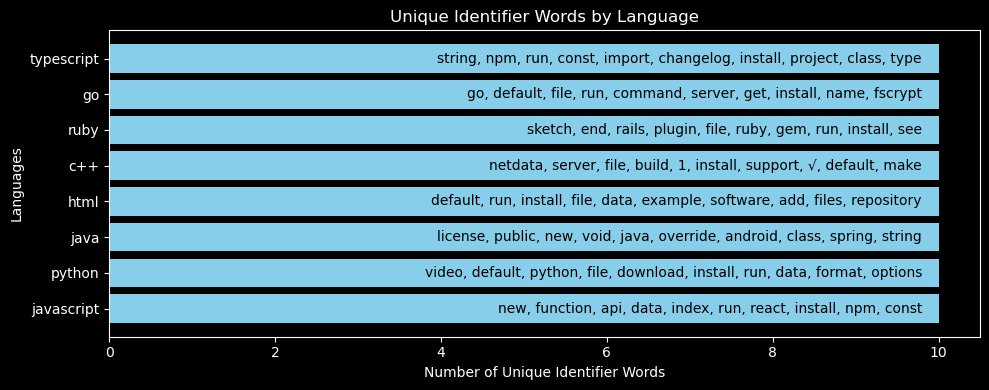

In [104]:
def top_words_for_language(lang, n=10):
    """Get the top n words for a given language."""
    text = " ".join(df[df['language'] == lang]['preprocessed_readme'])
    word_counts = Counter(text.split())
    return word_counts.most_common(n)

def is_word_unique_to_language(word, lang, threshold=0):
    """Check if a word is unique to a given language based on a threshold frequency in other languages."""
    total_occurrences = sum([1 for readme in df['preprocessed_readme'] if word in readme])
    lang_occurrences = sum([1 for readme in df[df['language'] == lang]['preprocessed_readme'] if word in readme])
    
    # If the word occurs predominantly in the given language, it's considered unique
    return (lang_occurrences / total_occurrences) > threshold

unique_identifier_words = {}

# For each language, identify potential unique identifier words
for lang in df['language'].unique():
    top_words = [word[0] for word in top_words_for_language(lang)]
    unique_words = [word for word in top_words if is_word_unique_to_language(word, lang)]
    unique_identifier_words[lang] = unique_words

import matplotlib.pyplot as plt

# Extract data for plotting
languages = list(unique_identifier_words.keys())
num_unique_words = [len(unique_identifier_words[lang]) for lang in languages]
unique_words = [", ".join(unique_identifier_words[lang]) for lang in languages]

# Create bar chart
plt.figure(figsize=(10, len(languages) * 0.5))  # Adjusting the height based on number of languages
bars = plt.barh(languages, num_unique_words, color='skyblue')

# Annotate bars with the unique words
for bar, words in zip(bars, unique_words):
    plt.text(bar.get_width() - (0.02 * max(num_unique_words)),  # Positioning the text a bit inside the bar's end
             bar.get_y() + bar.get_height()/2, 
             words, 
             va='center', ha='right', color='black', fontsize=10)

plt.xlabel('Number of Unique Identifier Words')
plt.ylabel('Languages')
plt.title('Unique Identifier Words by Language')
plt.tight_layout()
plt.show()

<div style="background-color: #; padding: 0px; ">

## <font size='5'><i>Plan → Acquire → Prepare → Explore → </i></font> <font size='10'><i>**Model**</i></font> <font size='5'><i>→ Deliver</i></font>
---

**Representation**:

****`BoW`****: Represents text as raw word counts. For instance, in a document, if the word "apple" appears 5 times, its representation in the **`BoW`** vector would be 5 for that word.

**`TF-IDF`**: Represents text based on the importance of each term relative to the entire corpus. It combines two metrics:
Term Frequency (TF): Measures the frequency of a term in a document (similar to **`BoW`**).
Inverse Document Frequency (IDF): Measures how unique or rare a term is across the entire corpus.

**Weighting**:

**`BoW`**: Gives equal weight to all terms. Common words in a language (like "the", "and", "is") that may appear frequently but offer little value in distinguishing documents will have high values.

**`TF-IDF`**: Weights terms based on their importance in the document relative to the entire corpus. Words that are frequent in a document but not across documents will have high **`TF-IDF`** scores.

**Use Cases**:

**`BoW`**: Given its simplicity, it can be effective for tasks where the sheer occurrence of words is important.

**`TF-IDF`**: Especially useful when you want to understand the importance or significance of words relative to the entire dataset. It can help in tasks like information retrieval, document search, and topic modeling.

**Dimensionality**:

For both **`BoW`** and **`TF-IDF`**, the dimensionality is equal to the size of the vocabulary. However, **`TF-IDF`** usually results in sparser vectors because many term weights will be zero (if the word is not in the document or has zero IDF).

### Term Frequency-Inverse Document Frequency (TF-IDF) 

Useful hyperparameters for `TfidfVectorizer`:

- `max_features`: This hyperparameter controls the maximum number of features (i.e., terms) to include in the TF-IDF matrix. Setting this to a smaller value can help reduce the dimensionality of the matrix and improve performance, especially if the dataset is large.

- `min_df` and `max_df`: These hyperparameters control the minimum and maximum document frequency of terms to include in the TF-IDF matrix. Setting `min_df` to a higher value will exclude terms that appear in fewer than `min_df` documents, while setting `max_df` to a lower value will exclude terms that appear in more than `max_df` documents. These can be useful for removing very rare or very common terms that may not be informative.

- `ngram_range`: This hyperparameter controls the range of n-grams to include in the TF-IDF matrix. An n-gram is a contiguous sequence of n words in a document. Setting `ngram_range` to `(1, 1)` will include only unigrams (i.e., single words), while setting it to `(1, 2)` will include both unigrams and bigrams (i.e., pairs of words).

- `stop_words`: This hyperparameter can be set to a list of stop words to exclude from the TF-IDF matrix. Stop words are common words that are unlikely to be informative, such as "the", "and", and "of".

- `tokenizer`: This hyperparameter can be set to a custom tokenizer function to use instead of the default tokenizer. The tokenizer function should take a string as input and return a list of tokens (i.e., words).

These hyperparameters can be tuned to improve the performance of the TF-IDF vectorization for a specific task or dataset.

In [52]:
# Perform TF-IDF with max_features 1000
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=300, ngram_range=(1,3), min_df=50, max_df=300)
X = tfidf.fit_transform(df['preprocessed_readme'])
y = df['language']

# Split the data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

# Train a Logistic Regression model
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression()
logit.fit(X_train, y_train)

# Calculate the accuracy of the model
print(f"Logistic Regression Train Accuracy: {logit.score(X_train, y_train)}")
print(f"Logistic Regression Test Accuracy: {logit.score(X_test, y_test)}")

Logistic Regression Train Accuracy: 0.8461538461538461
Logistic Regression Test Accuracy: 0.5842696629213483


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Split the data using the new random seed
X_train, X_test, y_train, y_test = train_test_split(df['preprocessed_readme'], df['language'], test_size=0.2, random_state=321)

# Create a pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression(max_iter=1000))
])

# Define the parameter grid
param_grid = {
    'tfidf__max_features': [500, 1000, 5000],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__min_df': [25, 50, 75],
    'tfidf__max_df': [250, 500, 750],
    'logreg__C': [0.1, 1, 10],
    'logreg__penalty': ['l1', 'l2']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=2, n_jobs=-1, verbose=2)

# Fit the grid search
grid_search.fit(X_train, y_train)

In [62]:
# Show results of grid search

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")
print(f"Test set score: {grid_search.score(X_test, y_test)}")

Best parameters: {'logreg__C': 1, 'logreg__penalty': 'l2', 'tfidf__max_df': 250, 'tfidf__max_features': 500, 'tfidf__min_df': 25, 'tfidf__ngram_range': (1, 2)}
Best cross-validation score: 0.5475352112676056
Test set score: 0.6363636363636364


In [152]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['preprocessed_readme'], df['language'], test_size=0.2, random_state=42)

# Define the TfidfVectorizer and LogisticRegression objects with the best hyperparameters
tfidf = TfidfVectorizer(max_df=250, max_features=500, min_df=25, ngram_range=(1, 2))
logreg = LogisticRegression(C=1, penalty='l2')

# Initialize the pipeline with the TfidfVectorizer and LogisticRegression objects
pipeline = Pipeline([('tfidf', tfidf), ('logreg', logreg)])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Predict the language labels for the test data
y_pred = pipeline.predict(X_test)

# Calculate the accuracy score for the test data
accuracy = accuracy_score(y_test, y_pred)

# Print the best hyperparameters and accuracy score
print(f"Best parameters: {pipeline.named_steps}")
print(f"Best cross-validation score: {pipeline.score(X_train, y_train)}")
print(f"Test set score: {accuracy}")

Best parameters: {'tfidf': TfidfVectorizer(max_df=250, max_features=500, min_df=25, ngram_range=(1, 2)), 'logreg': LogisticRegression(C=1)}
Best cross-validation score: 0.8767605633802817
Test set score: 0.5664335664335665


In [75]:
import pickle

# Save the TfidfVectorizer object
with open("support_files/tfidf_vectorizer.pkl", "wb") as file:
    pickle.dump(pipeline.named_steps['tfidf'], file)

# Save the LogisticRegression object
with open("support_files/logreg_model.pkl", "wb") as file:
    pickle.dump(pipeline.named_steps['logreg'], file)

Improving this performance might require:

- Trying more sophisticated models or ensemble techniques.
- Including more features, like N-grams or word embeddings.
- Acquiring more data, especially for underrepresented languages.
- Hyperparameter tuning for the chosen model.

## Function(ize) It

## Testing the Functions (With our pulled Repos)

In [149]:
import random
import pandas as pd
import joblib

def predict_language(readme_string=None, preprocess_func=preprocess_text, tfidf_path = "support_files/tfidf_vectorizer.pkl", logreg_path = "support_files/logreg_model.pkl"):
    """
    Predict the language of a readme string.

    Parameters:
    - readme_string (str): The input README string. If None, a random string will be selected from the CSV file.
    - preprocess_func (function): The function to preprocess the input text.
    - tfidf_path (str): Path to the saved TfidfVectorizer .pkl file.
    - logreg_path (str): Path to the saved LogisticRegression model .pkl file.

    Returns:
    - str: Predicted language label.
    """
    
    # If no readme_string is provided, select a random one from the CSV file
    if readme_string is None:
        df = pd.read_csv('support_files/all_readmes_processed.csv')
        random_index = random.randint(0, len(df)-1)
        readme_string = df.loc[random_index, 'preprocessed_readme']
        print(f"Random String: {readme_string}\n")
        print(f"Actual Language: {df.loc[random_index, 'language']}")
        
    # Preprocess the input string
    preprocessed_string = preprocess_func(readme_string)
    
    # Load the TfidfVectorizer and transform the string
    tfidf_vectorizer = joblib.load(tfidf_path)
    transformed_string = tfidf_vectorizer.transform([preprocessed_string])
    
    # Load the LogisticRegression model and predict
    logreg_model = joblib.load(logreg_path)
    prediction = logreg_model.predict(transformed_string)

    # Return the predicted language
    print(f'Predicted: {prediction[0]}')

In [150]:
predict_language()

Random String: overmind project aims provider complete server provisioning configuration management application first version unified front end public private clouds custom server providers dedicated hardware features ec2 rackspace server provisioning clouds supported libcloud supported given enough testing provider plugins provider integrated writing either libcloud driver overmind provisioning plugin import server overmind witht dedicated hardware plugin complete rest api provider nodes authentication three user roles see wiki architectural info installation requirements python 26 django 13 apache libcloud django celery rabbitmq alternative message queue supported celery python dependencies installed using requirements file pip install r requirementstxt install overmind download last stable release unpack create db changing overmind directory running python managepy syncdb testing purposes start celery server console python managepy celeryd l info django development server python man

## Testing the Functions (With a Random README String)

In [151]:
readme = '''BigML Python Bindings
=====================

`BigML <https://bigml.com>`_ makes machine learning easy by taking care
of the details required to add data-driven decisions and predictive
power to your company. Unlike other machine learning services, BigML
creates
`beautiful predictive models <https://bigml.com/gallery/models>`_ that
can be easily understood and interacted with.

These BigML Python bindings allow you to interact with
`BigML.io <https://bigml.io/>`_, the API
for BigML. You can use it to easily create, retrieve, list, update, and
delete BigML resources (i.e., sources, datasets, models and,
predictions). For additional information, see
the `full documentation for the Python
bindings on Read the Docs <http://bigml.readthedocs.org>`_.

This module is licensed under the `Apache License, Version
2.0 <http://www.apache.org/licenses/LICENSE-2.0.html>`_.

Support
-------

Please report problems and bugs to our `BigML.io issue
tracker <https://github.com/bigmlcom/io/issues>`_.

Discussions about the different bindings take place in the general
`BigML mailing list <http://groups.google.com/group/bigml>`_. Or join us
in our `Campfire chatroom <https://bigmlinc.campfirenow.com/f20a0>`_.

Requirements
------------

Only ``Python 3`` versions are currently supported by these bindings.
Support for Python 2.7.X ended in version ``4.32.3``.

The basic third-party dependencies are the
`requests <https://github.com/kennethreitz/requests>`_,
`unidecode <http://pypi.python.org/pypi/Unidecode/#downloads>`_,
`requests-toolbelt <https://pypi.python.org/pypi/requests-toolbelt>`_,
`bigml-chronos <https://pypi.org/project/bigml-chronos>`_,
`msgpack <https://pypi.org/project/msgpack>`_,
`numpy <http://www.numpy.org/>`_ and
`scipy <http://www.scipy.org/>`_ libraries. These
libraries are automatically installed during the basic setup.
Support for Google App Engine has been added as of version 3.0.0,
using the `urlfetch` package instead of `requests`.

The bindings will also use ``simplejson`` if you happen to have it
installed, but that is optional: we fall back to Python's built-in JSON
libraries is ``simplejson`` is not found.

The bindings provide support to use the ``BigML`` platform to create, update,
get and delete resources, but also to produce local predictions using the
models created in ``BigML``. Most of them will be actionable with the basic
installation, but some additional dependencies are needed to use local
``Topic Models`` and Image Processing models. Please, refer to the
`Installation <#installation>`_ section for details.

OS Requirements
~~~~~~~~~~~~~~~

The basic installation of the bindings is compatible and can be used
on Linux and Windows based Operating Systems.
However, the extra options that allow working with
image processing models (``[images]`` and ``[full]``) are only supported
and tested on Linux-based Operating Systems.
For image models, Windows OS is not recommended and cannot be supported out of
the box, because the specific compiler versions or dlls required are
unavailable in general.

Installation
------------

To install the basic latest stable release with
`pip <http://www.pip-installer.org/>`_, please use:

.. code-block:: bash

    $ pip install bigml

Support for local Topic Distributions (Topic Models' predictions)
and local predictions for datasets that include Images will only be
available as extras, because the libraries used for that are not
usually available in all Operative Systems. If you need to support those,
please check the `Installation Extras <#installation-extras>`_ section.

Installation Extras
-------------------

Local Topic Distributions support can be installed using:

.. code-block:: bash

    pip install bigml[topics]

Images local predictions support can be installed using:

.. code-block:: bash

    pip install bigml[images]

The full set of features can be installed using:

.. code-block:: bash

    pip install bigml[full]


WARNING: Mind that installing these extras can require some extra work, as
explained in the `Requirements <#requirements>`_ section.

You can also install the development version of the bindings directly
from the Git repository

.. code-block:: bash

    $ pip install -e git://github.com/bigmlcom/python.git#egg=bigml_python


Running the Tests
-----------------

The tests will be run using `pytest <https://docs.pytest.org/en/7.2.x/>`_.
You'll need to set up your authentication
via environment variables, as explained
in the authentication section. Also some of the tests need other environment
variables like ``BIGML_ORGANIZATION`` to test calls when used by Organization
members and ``BIGML_EXTERNAL_CONN_HOST``, ``BIGML_EXTERNAL_CONN_PORT``,
``BIGML_EXTERNAL_CONN_DB``, ``BIGML_EXTERNAL_CONN_USER``,
``BIGML_EXTERNAL_CONN_PWD`` and ``BIGML_EXTERNAL_CONN_SOURCE``
in order to test external data connectors.

With that in place, you can run the test suite simply by issuing

.. code-block:: bash

    $ pytest

Additionally, `Tox <http://tox.testrun.org/>`_ can be used to
automatically run the test suite in virtual environments for all
supported Python versions.  To install Tox:

.. code-block:: bash

    $ pip install tox

Then run the tests from the top-level project directory:

.. code-block:: bash

    $ tox

Importing the module
--------------------

To import the module:

.. code-block:: python

    import bigml.api

Alternatively you can just import the BigML class:

.. code-block:: python

    from bigml.api import BigML

Authentication
--------------

All the requests to BigML.io must be authenticated using your username
and `API key <https://bigml.com/account/apikey>`_ and are always
transmitted over HTTPS.

This module will look for your username and API key in the environment
variables ``BIGML_USERNAME`` and ``BIGML_API_KEY`` respectively.

Unix and MacOS
--------------

You can
add the following lines to your ``.bashrc`` or ``.bash_profile`` to set
those variables automatically when you log in:

.. code-block:: bash

    export BIGML_USERNAME=myusername
    export BIGML_API_KEY=ae579e7e53fb9abd646a6ff8aa99d4afe83ac291

refer to the next chapters to know how to do that in other operating systems.

With that environment set up, connecting to BigML is a breeze:

.. code-block:: python

    from bigml.api import BigML
    api = BigML()

Otherwise, you can initialize directly when instantiating the BigML
class as follows:

.. code-block:: python

    api = BigML('myusername', 'ae579e7e53fb9abd646a6ff8aa99d4afe83ac291')

These credentials will allow you to manage any resource in your user
environment.

In BigML a user can also work for an ``organization``.
In this case, the organization administrator should previously assign
permissions for the user to access one or several particular projects
in the organization.
Once permissions are granted, the user can work with resources in a project
according to his permission level by creating a special constructor for
each project. The connection constructor in this case
should include the ``project ID``:

.. code-block:: python

    api = BigML('myusername', 'ae579e7e53fb9abd646a6ff8aa99d4afe83ac291',
                project='project/53739b98d994972da7001d4a')

If the project used in a connection object
does not belong to an existing organization but is one of the
projects under the user's account, all the resources
created or updated with that connection will also be assigned to the
specified project.

When the resource to be managed is a ``project`` itself, the connection
needs to include the corresponding``organization ID``:

.. code-block:: python

    api = BigML('myusername', 'ae579e7e53fb9abd646a6ff8aa99d4afe83ac291',
                organization='organization/53739b98d994972da7025d4a')


Authentication on Windows
-------------------------

The credentials should be permanently stored in your system using

.. code-block:: bash

    setx BIGML_USERNAME myusername
    setx BIGML_API_KEY ae579e7e53fb9abd646a6ff8aa99d4afe83ac291

Note that ``setx`` will not change the environment variables of your actual
console, so you will need to open a new one to start using them.


Authentication on Jupyter Notebook
----------------------------------

You can set the environment variables using the ``%env`` command in your
cells:

.. code-block:: bash

    %env BIGML_USERNAME=myusername
    %env BIGML_API_KEY=ae579e7e53fb9abd646a6ff8aa99d4afe83ac291


Alternative domains
-------------------


The main public domain for the API service is ``bigml.io``, but there are some
alternative domains, either for Virtual Private Cloud setups or
the australian subdomain (``au.bigml.io``). You can change the remote
server domain
to the VPC particular one by either setting the ``BIGML_DOMAIN`` environment
variable to your VPC subdomain:

.. code-block:: bash

    export BIGML_DOMAIN=my_VPC.bigml.io

or setting it when instantiating your connection:

.. code-block:: python

    api = BigML(domain="my_VPC.bigml.io")

The corresponding SSL REST calls will be directed to your private domain
henceforth.

You can also set up your connection to use a particular PredictServer
only for predictions. In order to do so, you'll need to specify a ``Domain``
object, where you can set up the general domain name as well as the
particular prediction domain name.

.. code-block:: python

    from bigml.domain import Domain
    from bigml.api import BigML

    domain_info = Domain(prediction_domain="my_prediction_server.bigml.com",
                         prediction_protocol="http")

    api = BigML(domain=domain_info)

Finally, you can combine all the options and change both the general domain
server, and the prediction domain server.

.. code-block:: python

    from bigml.domain import Domain
    from bigml.api import BigML
    domain_info = Domain(domain="my_VPC.bigml.io",
                         prediction_domain="my_prediction_server.bigml.com",
                         prediction_protocol="https")

    api = BigML(domain=domain_info)

Some arguments for the Domain constructor are more unsual, but they can also
be used to set your special service endpoints:

- protocol (string) Protocol for the service
  (when different from HTTPS)
- verify (boolean) Sets on/off the SSL verification
- prediction_verify (boolean) Sets on/off the SSL verification
  for the prediction server (when different from the general
  SSL verification)

**Note** that the previously existing ``dev_mode`` flag:

.. code-block:: python

    api = BigML(dev_mode=True)

that caused the connection to work with the Sandbox ``Development Environment``
has been **deprecated** because this environment does not longer exist.
The existing resources that were previously
created in this environment have been moved
to a special project in the now unique ``Production Environment``, so this
flag is no longer needed to work with them.


Quick Start
-----------

Imagine that you want to use `this csv
file <https://static.bigml.com/csv/iris.csv>`_ containing the `Iris
flower dataset <http://en.wikipedia.org/wiki/Iris_flower_data_set>`_ to
predict the species of a flower whose ``petal length`` is ``2.45`` and
whose ``petal width`` is ``1.75``. A preview of the dataset is shown
below. It has 4 numeric fields: ``sepal length``, ``sepal width``,
``petal length``, ``petal width`` and a categorical field: ``species``.
By default, BigML considers the last field in the dataset as the
objective field (i.e., the field that you want to generate predictions
for).

::

    sepal length,sepal width,petal length,petal width,species
    5.1,3.5,1.4,0.2,Iris-setosa
    4.9,3.0,1.4,0.2,Iris-setosa
    4.7,3.2,1.3,0.2,Iris-setosa
    ...
    5.8,2.7,3.9,1.2,Iris-versicolor
    6.0,2.7,5.1,1.6,Iris-versicolor
    5.4,3.0,4.5,1.5,Iris-versicolor
    ...
    6.8,3.0,5.5,2.1,Iris-virginica
    5.7,2.5,5.0,2.0,Iris-virginica
    5.8,2.8,5.1,2.4,Iris-virginica

You can easily generate a prediction following these steps:

.. code-block:: python

    from bigml.api import BigML

    api = BigML()

    source = api.create_source('./data/iris.csv')
    dataset = api.create_dataset(source)
    model = api.create_model(dataset)
    prediction = api.create_prediction(model, \
        {"petal width": 1.75, "petal length": 2.45})

You can then print the prediction using the ``pprint`` method:

.. code-block:: python

    >>> api.pprint(prediction)
    species for {"petal width": 1.75, "petal length": 2.45} is Iris-setosa

Certainly, any of the resources created in BigML can be configured using
several arguments described in the `API documentation <https://bigml.com/api>`_.
Any of these configuration arguments can be added to the ``create`` method
as a dictionary in the last optional argument of the calls:

.. code-block:: python

    from bigml.api import BigML

    api = BigML()

    source_args = {"name": "my source",
         "source_parser": {"missing_tokens": ["NULL"]}}
    source = api.create_source('./data/iris.csv', source_args)
    dataset_args = {"name": "my dataset"}
    dataset = api.create_dataset(source, dataset_args)
    model_args = {"objective_field": "species"}
    model = api.create_model(dataset, model_args)
    prediction_args = {"name": "my prediction"}
    prediction = api.create_prediction(model, \
        {"petal width": 1.75, "petal length": 2.45},
        prediction_args)

The ``iris`` dataset has a small number of instances, and usually will be
instantly created, so the ``api.create_`` calls will probably return the
finished resources outright. As BigML's API is asynchronous,
in general you will need to ensure
that objects are finished before using them by using ``api.ok``.

.. code-block:: python

    from bigml.api import BigML

    api = BigML()

    source = api.create_source('./data/iris.csv')
    api.ok(source)
    dataset = api.create_dataset(source)
    api.ok(dataset)
    model = api.create_model(dataset)
    api.ok(model)
    prediction = api.create_prediction(model, \
        {"petal width": 1.75, "petal length": 2.45})

Note that the prediction
call is not followed by the ``api.ok`` method. Predictions are so quick to be
generated that, unlike the
rest of resouces, will be generated synchronously as a finished object.

The example assumes that your objective field (the one you want to predict)
is the last field in the dataset. If that's not he case, you can explicitly
set the name of this field in the creation call using the ``objective_field``
argument:


.. code-block:: python

    from bigml.api import BigML

    api = BigML()

    source = api.create_source('./data/iris.csv')
    api.ok(source)
    dataset = api.create_dataset(source)
    api.ok(dataset)
    model = api.create_model(dataset, {"objective_field": "species"})
    api.ok(model)
    prediction = api.create_prediction(model, \
        {'sepal length': 5, 'sepal width': 2.5})


You can also generate an evaluation for the model by using:

.. code-block:: python

    test_source = api.create_source('./data/test_iris.csv')
    api.ok(test_source)
    test_dataset = api.create_dataset(test_source)
    api.ok(test_dataset)
    evaluation = api.create_evaluation(model, test_dataset)
    api.ok(evaluation)

If you set the ``storage`` argument in the ``api`` instantiation:

.. code-block:: python

    api = BigML(storage='./storage')

all the generated, updated or retrieved resources will be automatically
saved to the chosen directory.

Alternatively, you can use the ``export`` method to explicitly
download the JSON information
that describes any of your resources in BigML to a particular file:

.. code-block:: python

    api.export('model/5acea49a08b07e14b9001068',
               filename="my_dir/my_model.json")

This example downloads the JSON for the model and stores it in
the ``my_dir/my_model.json`` file.

In the case of models that can be represented in a `PMML` syntax, the
export method can be used to produce the corresponding `PMML` file.

.. code-block:: python

    api.export('model/5acea49a08b07e14b9001068',
               filename="my_dir/my_model.pmml",
               pmml=True)

You can also retrieve the last resource with some previously given tag:

.. code-block:: python

     api.export_last("foo",
                     resource_type="ensemble",
                     filename="my_dir/my_ensemble.json")

which selects the last ensemble that has a ``foo`` tag. This mechanism can
be specially useful when retrieving retrained models that have been created
with a shared unique keyword as tag.

For a descriptive overview of the steps that you will usually need to
follow to model
your data and obtain predictions, please see the `basic Workflow sketch
<api_sketch.html>`_
document. You can also check other simple examples in the following documents:

- `model 101 <101_model.html>`_
- `logistic regression 101 <101_logistic_regression.html>`_
- `linear regression 101 <101_linear_regression.html>`_
- `ensemble 101 <101_ensemble.html>`_
- `cluster 101 <101_cluster>`_
- `anomaly detector 101 <101_anomaly.html>`_
- `association 101 <101_association.html>`_
- `topic model 101 <101_topic_model.html>`_
- `deepnet 101 <101_deepnet.html>`_
- `time series 101 <101_ts.html>`_
- `fusion 101 <101_fusion.html>`_
- `scripting 101 <101_scripting.html>`_

Additional Information
----------------------

We've just barely scratched the surface. For additional information, see
the `full documentation for the Python
bindings on Read the Docs <http://bigml.readthedocs.org>`_.
Alternatively, the same documentation can be built from a local checkout
of the source by installing `Sphinx <http://sphinx.pocoo.org>`_
(``$ pip install sphinx``) and then running

.. code-block:: bash

    $ cd docs
    $ make html

Then launch ``docs/_build/html/index.html`` in your browser.

How to Contribute
-----------------

Please follow the next steps:

  1. Fork the project on github.com.
  2. Create a new branch.
  3. Commit changes to the new branch.
  4. Send a `pull request <https://github.com/bigmlcom/python/pulls>`_.


For details on the underlying API, see the
`BigML API documentation <https://bigml.com/developers>`_.'''

predict_language(readme_string=readme)

Predicted: python


<div style="background-color: #; padding: 0px; ">

## <font size='5'><i>Plan → Acquire → Prepare → Explore → Model →</i></font> <font size='10'><i>**Deliver**</i></font>
---